In [1]:
#导入库cell
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
import math
from scipy.spatial import distance_matrix, ConvexHull
import random
from random import choice
import os
from PIL import Image
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy.spatial.distance import pdist, squareform
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

# 修改plt默认图形大小
plt.rcParams['figure.figsize'] = [5, 5]
# 修改默认字体大小
plt.rcParams['font.size'] = 12
# 修改默认坐标轴标签的字体
plt.rcParams['axes.labelsize'] = 10

In [2]:
#定义函数cell
# 计算两点之间的距离
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# 计算两线段的角度
def calculate_angle(p1, p2):
    return math.degrees(math.atan2(p2[1] - p1[1], p2[0] - p1[0]))

# 计算点到线段的最短距离
def point_to_line_distance(point, line):
    p1, p2 = line
    line_vector = np.array(p2) - np.array(p1)
    point_vector = np.array(point) - np.array(p1)
    line_length = np.linalg.norm(line_vector)
    unit_line_vector = line_vector / line_length
    projected_point_length = np.dot(point_vector, unit_line_vector)
    if projected_point_length < 0:
        return calculate_distance(point, p1)
    elif projected_point_length > line_length:
        return calculate_distance(point, p2)
    else:
        projected_point = p1 + projected_point_length * unit_line_vector
        return calculate_distance(point, projected_point)
        
def angle_between(v1, v2):
    # 计算两个向量之间的角度
    return np.degrees(np.arccos(np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1.0, 1.0)))
    
# 判断两线段的一致性
def check_consistency(line1, line2):
    # 判断角度差
    angle1 = calculate_angle(*line1)
    angle2 = calculate_angle(*line2)
    if abs(angle1 - angle2) > 10:
        return False

    # 判断线段1中点到线段2所在直线的垂直距离
    midpoint_line1 = [(line1[0][0]+line1[1][0])/2, (line1[0][1]+line1[1][1])/2]
    if point_to_line_distance(midpoint_line1, line2) > 30:
        return False

    # 判断以线段为直径的圆的关系
    c1 = [(line1[0][0]+line1[1][0])/2, (line1[0][1]+line1[1][1])/2]
    c2 = [(line2[0][0]+line2[1][0])/2, (line2[0][1]+line2[1][1])/2]
    r1 = calculate_distance(line1[0], line1[1]) / 2
    r2 = calculate_distance(line2[0], line2[1]) / 2
    d = calculate_distance(c1, c2)
    if d > r1+r2:
        return False

    return True
def find_matching_lines(lines1, lines2):
    lines3 = []
    for line1 in lines1:
        for line2 in lines2:
            if check_consistency(line1, line2):
                lines3.append(line1)
                break
    return lines3

def generate_web(points):
    # 计算所有点之间的距离
    distances = squareform(pdist(points))

    # 对每个点，找到最近的n个点，并生成线段
    lines = []
    for i in range(len(points)):
        nearest_indices = np.argsort(distances[i])[:12]  # 包括自己，所以取n+1个
        temp_lines = []
        for j in nearest_indices:
            if i != j:  # 排除自己
                line = np.array([points[i], points[j]])
                if np.linalg.norm(line[0] - line[1]) > 15:  # 线段长度必须大于9
                    temp_lines.append(line)

        # 对每个点生成的线段进行角度判断
        for k in range(len(temp_lines)):
            for l in range(k+1, len(temp_lines)):
                v1 = temp_lines[k][1] - temp_lines[k][0]
                v2 = temp_lines[l][1] - temp_lines[l][0]
                if angle_between(v1, v2) < 5:  # 如果两条线段角度小于五度
                    if np.linalg.norm(v1) < np.linalg.norm(v2):  # 保留较短的那条
                        temp_lines[l] = temp_lines[k]
                    else:
                        temp_lines[k] = temp_lines[l]
        lines.extend(temp_lines)
    return np.array(lines)

In [3]:
#调参cell
#调整角点识别参数
def gfttp(paramter1, paramter2, paramter3, paramter4, paramter5, paramter6):
    print('角点识别')
    print(f'maxCorners要检测的最大角点数目。如果超过此数目，将返回最强的角点: {paramter1}')
    print(f'qualityLevel角点的质量水平阈值。范围是0到1之间，表示角点质量的最小阈值: {paramter2}')
    print(f'minDistance两个角点之间的最小欧几里德距离。如果两个角点的距离小于此值，则只有其中一个会被保留: {paramter3}')
    print(f'blockSize：角点检测时的窗口大小。这个参数影响角点检测的精度: {paramter4}')
    print(f'useHarrisDetector一个布尔值，如果为True，则使用Harris角点检测器，如果为False，则使用Shi-Tomasi角点检测器: {paramter5}')
    print(f'k：Harris角点检测器的自由参数k。它影响角点响应函数的灵敏度，一般是0.04，减小能使检测器更灵敏: {paramter6} ')
    return paramter1, paramter2, paramter3, paramter4, paramter5, paramter6
#调整线段识别参数
def hlpp(paramter1, paramter2, paramter3, paramter4, paramter5):
    print('线段识别')
    print(f'rho：极坐标中的距离精度，通常设置为1像素: {paramter1}')
    print(f'theta：极坐标中的角度精度，通常设置为π/180，表示1度: {paramter2}')
    print(f'threshold：阈值，用于确定一条直线所需的最小投票数。只有在投票数超过这个阈值时，直线才会被检测到: {paramter3}')
    print(f'blockSize：minLineLength：线段的最小长度。小于此长度的线段将被忽略: {paramter4}')
    print(f'maxLineGap：在两条线段之间认为是一条直线的最大距离。如果两条线段之间的距离小于此值，它们将被合并成一条直线: {paramter5}')
    return paramter1, paramter2, paramter3, paramter4, paramter5



interactive_plot = interactive(gfttp, paramter1=(0,500,1), 
                               paramter2=(0.000,0.100,0.001),
                               paramter3=(1,50,1), 
                               paramter4=(1,10,1),
                               paramter5=(0,1,1),
                               paramter6=(0.00,0.10,0.01))
interactive_plot.children[0].value = 500
interactive_plot.children[1].value = 0.01
interactive_plot.children[2].value = 16
interactive_plot.children[3].value = 5
interactive_plot.children[4].value = 0
interactive_plot.children[5].value = 0.02

interactive_hlpp = interactive(hlpp, paramter1=(0,10,1), 
                               paramter2=(0,0.3141592653589793,0.017453292519943295),
                               paramter3=(0,100,1), 
                               paramter4=(0,100,1),
                               paramter5=(0,100,1))
interactive_hlpp.children[0].value = 1
interactive_hlpp.children[1].value = 0.017453292519943295
interactive_hlpp.children[2].value = 15
interactive_hlpp.children[3].value = 15
interactive_hlpp.children[4].value = 15
display(interactive_plot)
display(interactive_hlpp)

interactive(children=(IntSlider(value=500, description='paramter1', max=500), FloatSlider(value=0.01, descript…

interactive(children=(IntSlider(value=1, description='paramter1', max=10), FloatSlider(value=0.017453292519943…

In [4]:
def pic_corners_connections_detect(pic_dir, depth_dir, save_dir, interactive_plot, interactive_hlpp):
    img = cv2.imread(pic_dir)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    p1,p2,p3,p4,p5,p6 = interactive_plot.result
    corners = cv2.goodFeaturesToTrack(gray, maxCorners=p1, qualityLevel=p2, minDistance=p3, blockSize=int(p4), useHarrisDetector=p5, k=p6)
    corners = np.intp(corners)
    edges = cv2.Canny(gray, 40, 190, apertureSize=3)
    hlp1,hlp2,hlp3,hlp4,hlp5 = interactive_hlpp.result
    lines = cv2.HoughLinesP(edges, rho=hlp1, theta=hlp2, threshold=hlp3, minLineLength=hlp4, maxLineGap=hlp5)
    points1 = corners
    points1 = np.squeeze(points1)
    distances = distance_matrix(points1, points1)
    lines2 = lines
    lines2 = lines2.reshape(-1, 2)
    lines2 = lines2.reshape(-1, 2, 2)
    lines1 = generate_web(corners.reshape(-1,2))
    lines3 = find_matching_lines(lines1, lines2)
    lines3 = np.array(lines3)
    hull = ConvexHull(corners.reshape(-1,2))
    points = corners.reshape(-1,2)
    edges = []
    for simplex in hull.simplices:
        edge = points[simplex]
        edges.append(edge)
    edges = np.array(edges)
    corners = np.array(corners)
    corners = corners.reshape(-1,2)
    depth_img = cv2.imread(depth_dir, cv2.IMREAD_GRAYSCALE)
    if depth_img is None:
        print('无法读取图片')
        print(depth_dir)
        sys.exit()
    depth_values = depth_img[corners[:, 1], corners[:, 0]]
    points_depth = np.column_stack((corners, depth_values))
    points_depth = np.array(points_depth)
    np.savetxt(os.path.join(save_dir, 'points_depth.txt'), points_depth, fmt='%d', delimiter=', ')
    lines3 = lines3.reshape(-1, 2, 2)
    depth_values_start = depth_img[lines3[:, 0, 1], lines3[:, 0, 0]]
    depth_values_end = depth_img[lines3[:, 1, 1], lines3[:, 1, 0]]
    lines_depth_start = np.column_stack((lines3[:, 0, :], depth_values_start))
    lines_depth_end = np.column_stack((lines3[:, 1, :], depth_values_end))
    lines_depth = np.stack((lines_depth_start, lines_depth_end), axis=1)
    with open(os.path.join(save_dir, 'lines_depth.txt'), 'w') as f:
        for line in lines_depth:
            f.write(','.join(map(str, line[0])) + ' ' + ','.join(map(str, line[1])) + '\n')
    depth_values_edges_start = depth_img[edges[:, 0, 1], edges[:, 0, 0]]
    depth_values_edges_end = depth_img[edges[:, 1, 1], edges[:, 1, 0]]
    edges_depth_start = np.column_stack((edges[:, 0, :], depth_values_edges_start))
    edges_depth_end = np.column_stack((edges[:, 1, :], depth_values_edges_end))
    edges_depth = np.stack((edges_depth_start, edges_depth_end), axis=1)
    with open(os.path.join(save_dir, 'edges_depth.txt'), 'w') as f:
        for edge in edges_depth:
            f.write(','.join(map(str, edge[0])) + ' ' + ','.join(map(str, edge[1])) + '\n')
    cv2.imwrite(os.path.join(save_dir, 'source.png'),img)
    cv2.imwrite(os.path.join(save_dir, 'depth.png'),depth_img)
    blank_image = img
    for line in lines3.reshape(-1,4):
        x1, y1, x2, y2 = line
        cv2.line(blank_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.imwrite(os.path.join(save_dir, 'connectings.png'),blank_image)
    for line in edges.reshape(-1,4):
        x1, y1, x2, y2 = line
        cv2.line(blank_image, (x1, y1), (x2, y2), (0, 0, 255), 2)   
    cv2.imwrite(os.path.join(save_dir, 'connectings_withedge.png'),blank_image)
    for corner in corners.reshape(-1,2):
        x, y = corner
        cv2.circle(blank_image, (x, y), 3, 255, -1)  # 在角点位置绘制圆
    plt.imshow(blank_image)
    plt.show()
    print('检测到角点数目',len(corners),' 角点连线数目',len(lines1),' 检测连线数目',len(lines2),' 最终连线数目',len(lines3))


def dir_corners_connections_detect(pics_dir, depths_dir, saves_dir, interactive_plot, interactive_hlpp):
    pics = os.listdir(pics_dir)
    for pic in pics:
        pic_name = os.path.splitext(pic)[0]
        pic_dir = os.path.join(pics_dir, pic)
        depth_dir = os.path.join(depths_dir, pic_name + '_depth'+'.png')
        save_dir = os.path.join(saves_dir, pic_name)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        pic_corners_connections_detect(pic_dir, depth_dir, save_dir, interactive_plot, interactive_hlpp)


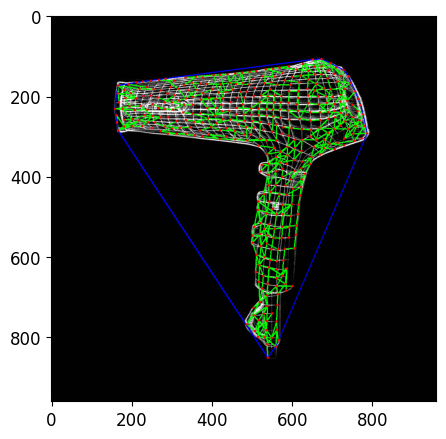

检测到角点数目 395  角点连线数目 3178  检测连线数目 989  最终连线数目 498


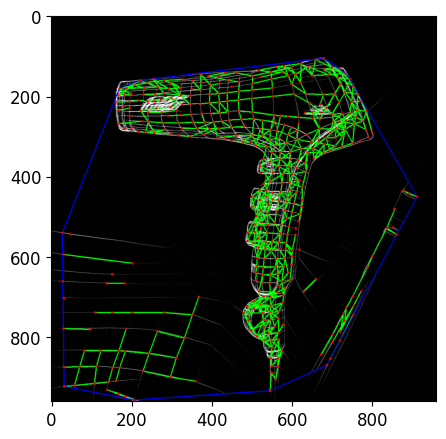

检测到角点数目 420  角点连线数目 3656  检测连线数目 1628  最终连线数目 668


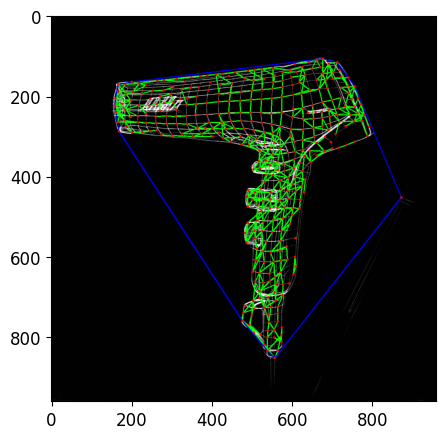

检测到角点数目 355  角点连线数目 3110  检测连线数目 1327  最终连线数目 519


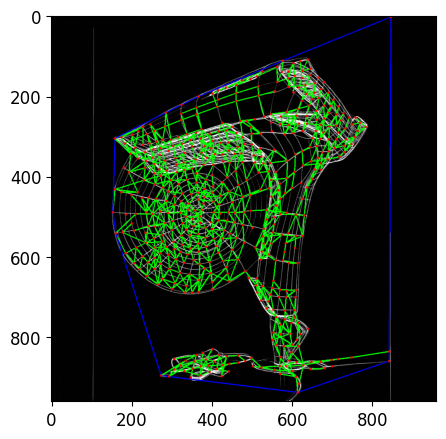

检测到角点数目 500  角点连线数目 4348  检测连线数目 2289  最终连线数目 847


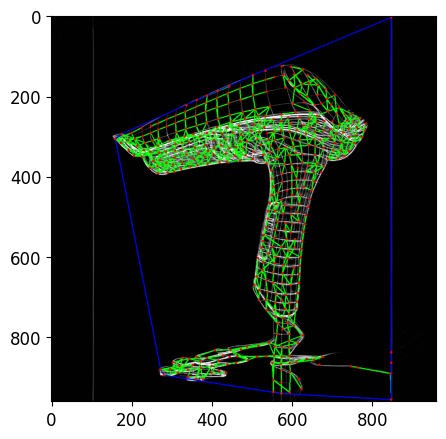

检测到角点数目 407  角点连线数目 3474  检测连线数目 1312  最终连线数目 657


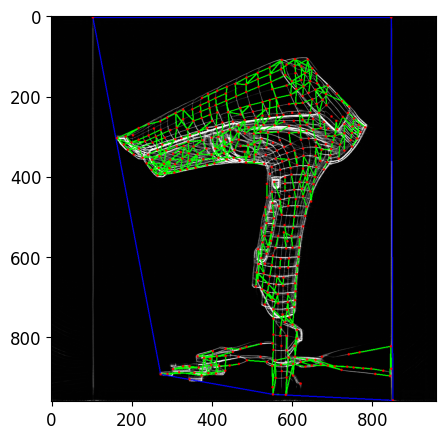

检测到角点数目 439  角点连线数目 3634  检测连线数目 1337  最终连线数目 507


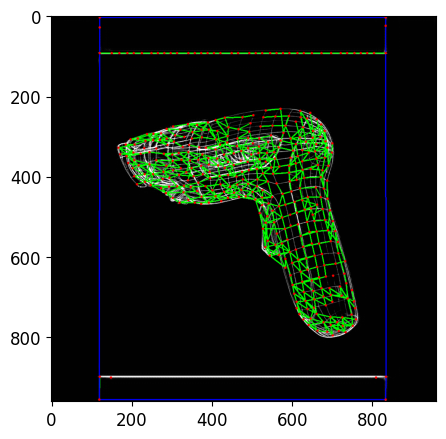

检测到角点数目 387  角点连线数目 3282  检测连线数目 1196  最终连线数目 747


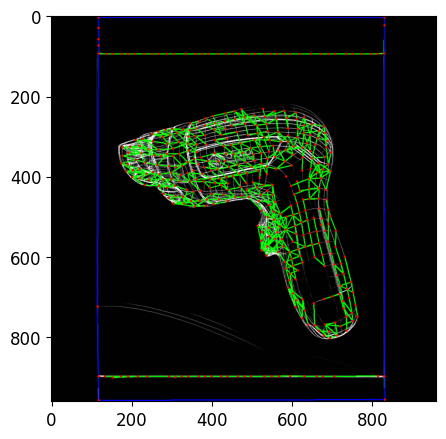

检测到角点数目 419  角点连线数目 3504  检测连线数目 1147  最终连线数目 780


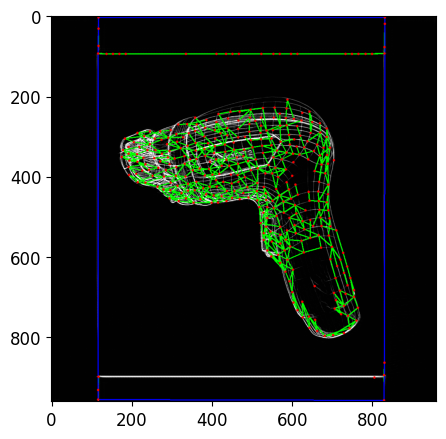

检测到角点数目 360  角点连线数目 3092  检测连线数目 1181  最终连线数目 588


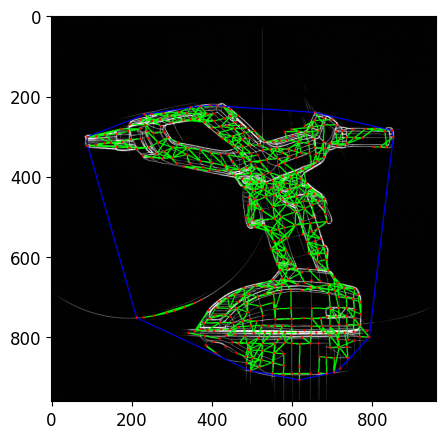

检测到角点数目 435  角点连线数目 3642  检测连线数目 1685  最终连线数目 741


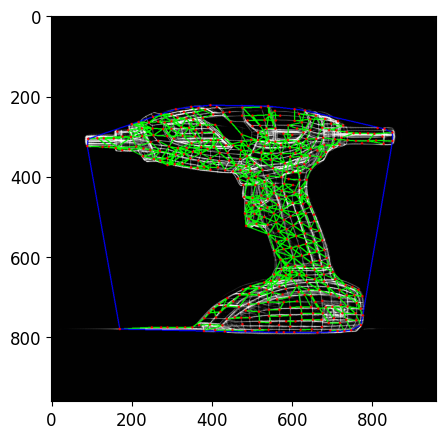

检测到角点数目 426  角点连线数目 3502  检测连线数目 1316  最终连线数目 689


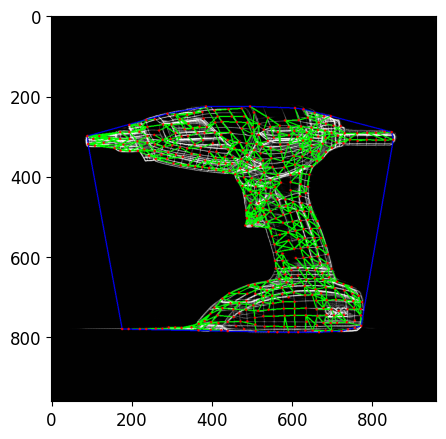

检测到角点数目 427  角点连线数目 3528  检测连线数目 1244  最终连线数目 779


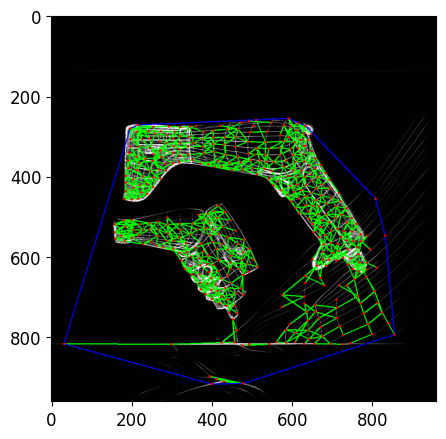

检测到角点数目 409  角点连线数目 3444  检测连线数目 1804  最终连线数目 796


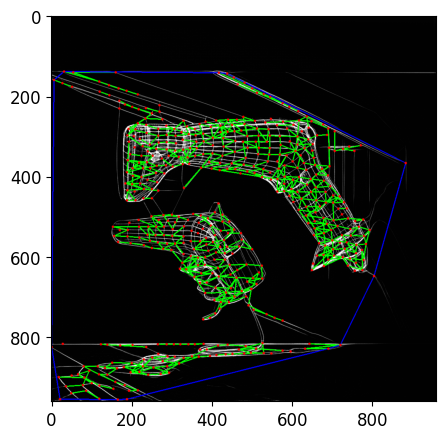

检测到角点数目 500  角点连线数目 4250  检测连线数目 1873  最终连线数目 650


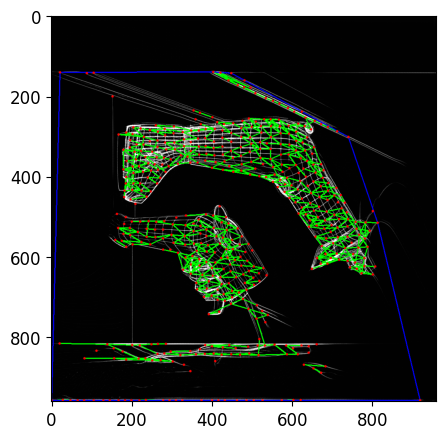

检测到角点数目 496  角点连线数目 4214  检测连线数目 1655  最终连线数目 731


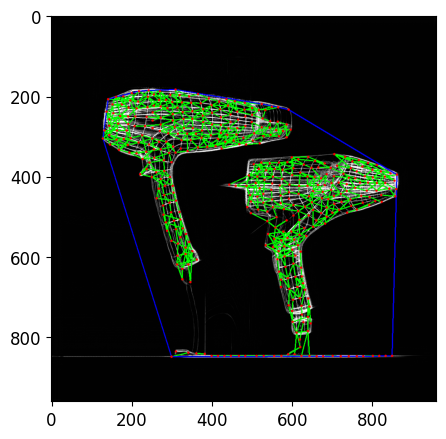

检测到角点数目 417  角点连线数目 3452  检测连线数目 1243  最终连线数目 765


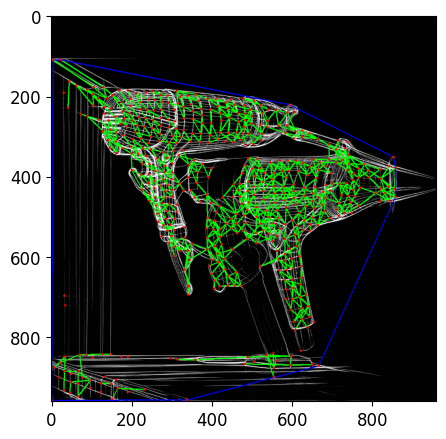

检测到角点数目 500  角点连线数目 4290  检测连线数目 2228  最终连线数目 763


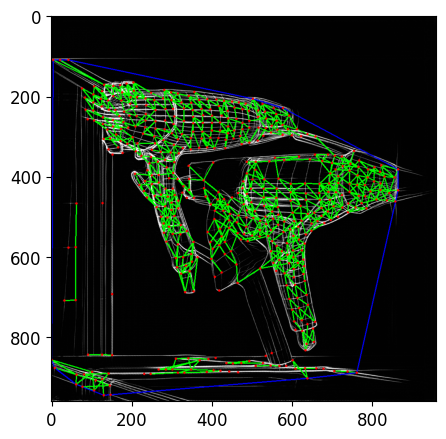

检测到角点数目 500  角点连线数目 4304  检测连线数目 2378  最终连线数目 840


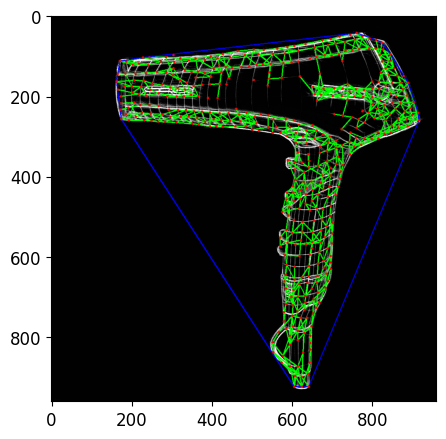

检测到角点数目 431  角点连线数目 3592  检测连线数目 1604  最终连线数目 686


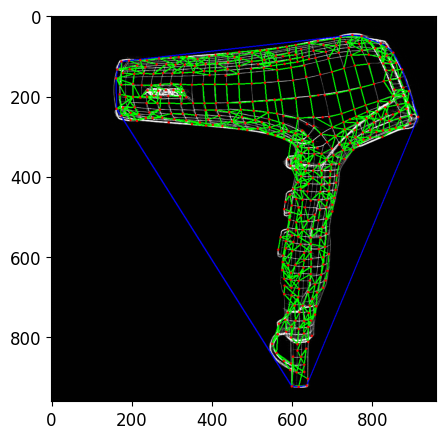

检测到角点数目 436  角点连线数目 3640  检测连线数目 1515  最终连线数目 738


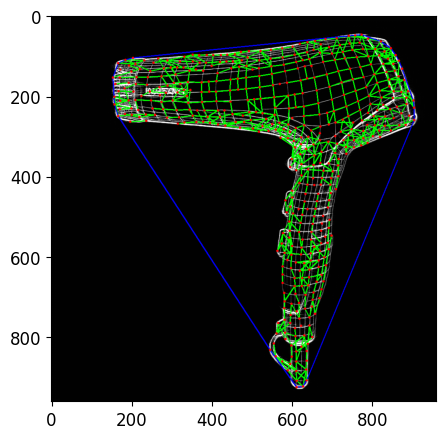

检测到角点数目 470  角点连线数目 3956  检测连线数目 1517  最终连线数目 685


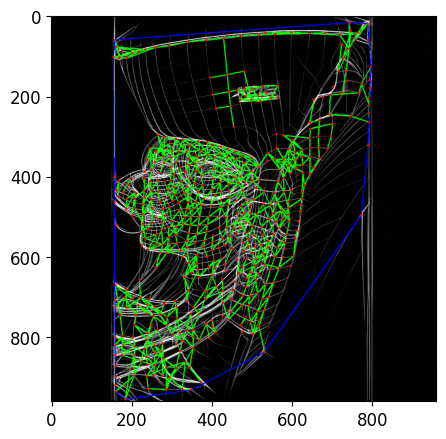

检测到角点数目 500  角点连线数目 4362  检测连线数目 2878  最终连线数目 805


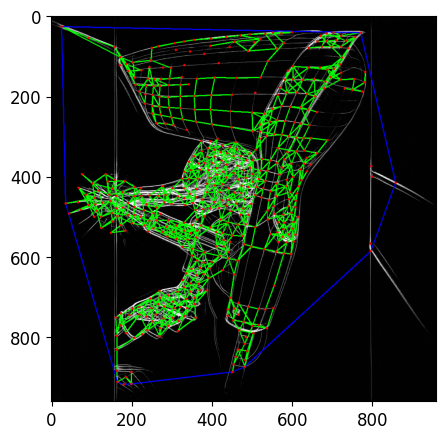

检测到角点数目 500  角点连线数目 4320  检测连线数目 2376  最终连线数目 952


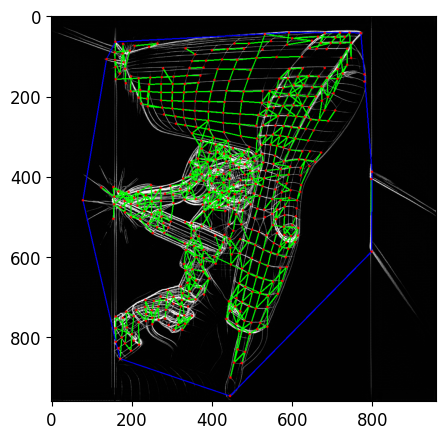

检测到角点数目 500  角点连线数目 4396  检测连线数目 2389  最终连线数目 753


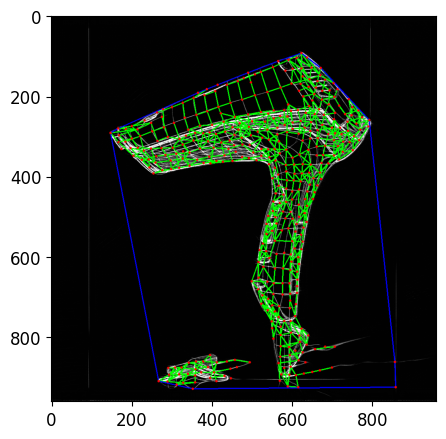

检测到角点数目 401  角点连线数目 3406  检测连线数目 1376  最终连线数目 711


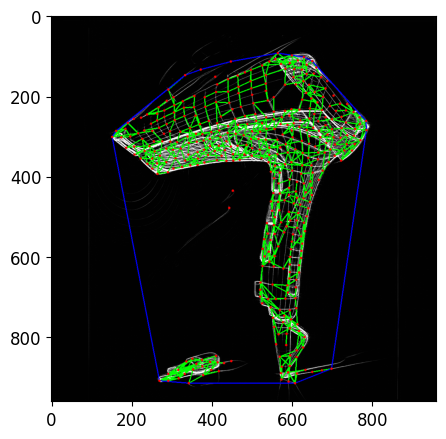

检测到角点数目 406  角点连线数目 3424  检测连线数目 1456  最终连线数目 648


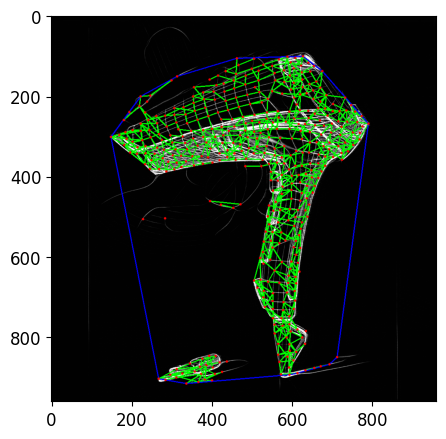

检测到角点数目 413  角点连线数目 3576  检测连线数目 1544  最终连线数目 772


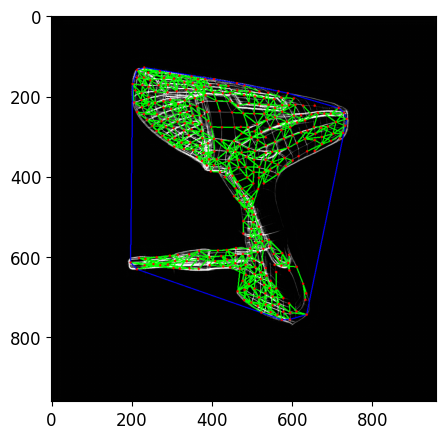

检测到角点数目 334  角点连线数目 2756  检测连线数目 1224  最终连线数目 663


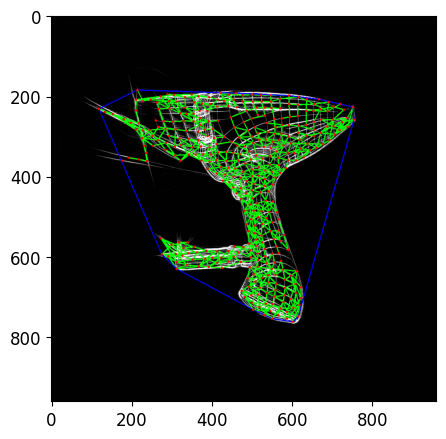

检测到角点数目 361  角点连线数目 2926  检测连线数目 1167  最终连线数目 679


KeyboardInterrupt: 

In [5]:
#批量处理cell
%%time
dir_corners_connections_detect('928\\hairdryer\\group_test_1\\ln', '928\\hairdryer\\group_test_1\\dp', '928\\hairdryer\\group_test_1\\sv', interactive_plot, interactive_hlpp)

image_read
检测到角点数目 422


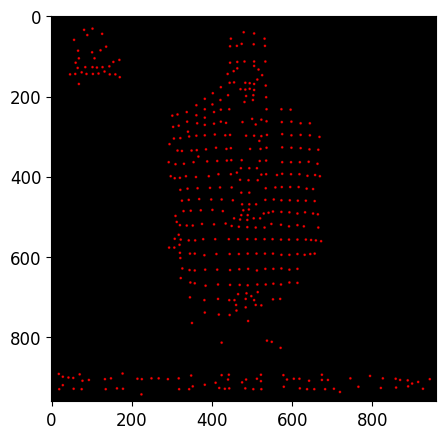

检测到连线数目 1854


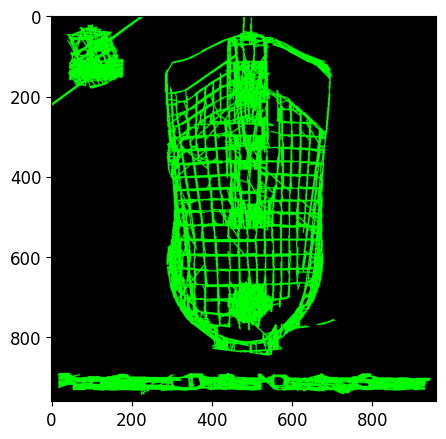

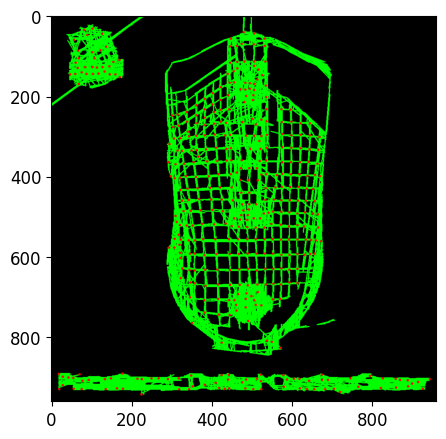

In [36]:
#角点识别与线段识别cell

img = cv2.imread('10-6-1.png')# 读取图像
if img is None:
    print("no_image")
    sys.exit()# 如果读取错误，则退出
else:
    print("image_read")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)# 转为灰度图像才能做角点检测
# 角点检测
p1,p2,p3,p4,p5,p6=interactive_plot.result
corners = cv2.goodFeaturesToTrack(gray, maxCorners=p1, qualityLevel=p2, minDistance=p3, blockSize=int(p4), useHarrisDetector=p5, k=p6)
corners = np.intp(corners)  # 转换为整数坐标
print('检测到角点数目',len(corners))
height, width, _ = img.shape
blank_image = np.zeros((height, width, 3), dtype=np.uint8)
for corner in corners:
    x, y = corner.ravel()  # 将角点坐标展平
    cv2.circle(blank_image, (x, y), 3, 255, -1)  # 在角点位置绘制圆
plt.imshow(blank_image)
plt.show()
edges = cv2.Canny(gray, 40, 190, apertureSize=3)
# 使用Hough变换检测直线
hlp1,hlp2,hlp3,hlp4,hlp5=interactive_hlpp.result
lines = cv2.HoughLinesP(edges, rho=hlp1, theta=hlp2, threshold=hlp3, minLineLength=hlp4, maxLineGap=hlp5)
if lines is None:
    print("该参数检测不到线段")
    sys.exit()
else:
    print("检测到连线数目 "+str(len(lines)))  
height, width, _ = img.shape
blank_image = np.zeros((height, width, 3), dtype=np.uint8)   
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(blank_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(blank_image)
plt.show()
for corner in corners:
    x, y = corner.ravel()  # 将角点坐标展平
    cv2.circle(blank_image, (x, y), 3, 255, -1)  # 在角点位置绘制圆
plt.imshow(blank_image)
plt.show()


角点生成网格


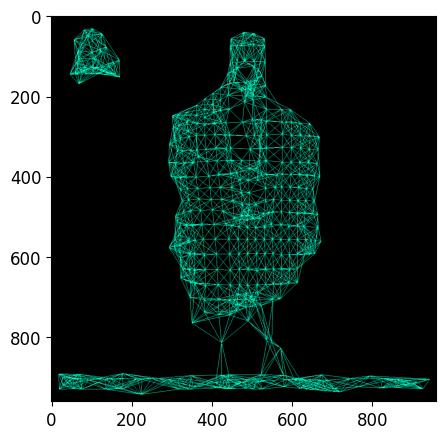

(4442, 2, 2)
(1854, 2, 2)
(1804, 2, 2)


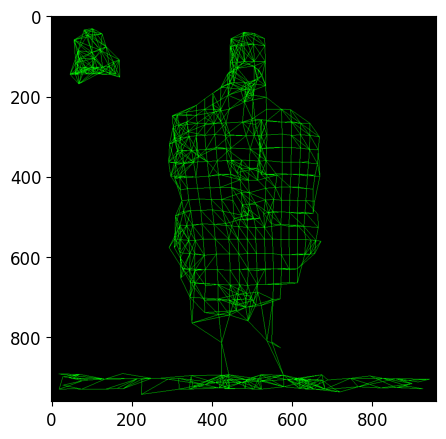

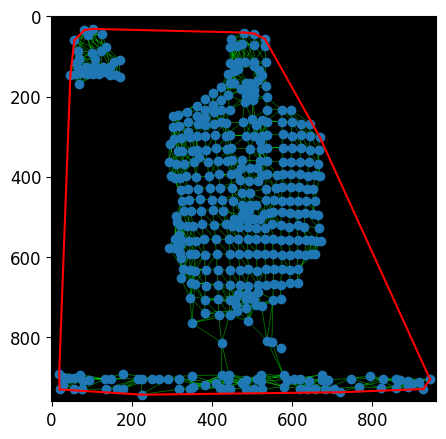

In [37]:
height, width, _ = img.shape
lines2=lines
lines2=lines2.reshape(-1, 2)
lines2=lines2.reshape(-1, 2, 2)
lines1 = generate_web(corners.reshape(-1,2))
blank_image = np.zeros((height, width, 3), dtype=np.uint8)
for line in lines1.reshape(-1,4):
    x1, y1, x2, y2 = line
    cv2.line(blank_image, (x1, y1), (x2, y2), (0, 255, 200), 1)
plt.imshow(blank_image)
print('角点生成网格')
plt.show()
print(lines1.shape)
print(lines2.shape)
lines3=find_matching_lines(lines1, lines2)
lines3 = np.array(lines3)
print(lines3.shape)
blank_image = np.zeros((height, width, 3), dtype=np.uint8)
for line in lines3.reshape(-1,4):
    x1, y1, x2, y2 = line
    cv2.line(blank_image, (x1, y1), (x2, y2), (0, 255, 0), 1)
plt.imshow(blank_image)
plt.show()
# 计算凸包
hull = ConvexHull(corners.reshape(-1,2))
points=corners.reshape(-1,2)
# 存储凸包的边
edges = []
for simplex in hull.simplices:
    edge = points[simplex]
    edges.append(edge)
edges = np.array(edges)
plt.imshow(blank_image)
plt.scatter(points[:,0], points[:,1])
for edge in edges:
    plt.plot(edge[:, 0], edge[:, 1], 'r')

plt.show()

935
[[(614, 603), (655, 596), (616, 628)], [(660, 623), (655, 596), (616, 628)], [(571, 627), (595, 591), (655, 596), (616, 628)], [(609, 652), (595, 591), (655, 596), (616, 628)], [(657, 610), (595, 591), (655, 596), (616, 628)], [(695, 594), (696, 572), (655, 596)], [(718, 569), (708, 539), (696, 572)], [(700, 604), (710, 582), (708, 539), (696, 572)], [(695, 594), (710, 582), (708, 539), (696, 572)], [(707, 563), (710, 582), (708, 539)], [(687, 584), (710, 582), (708, 539), (696, 572), (655, 596)], [(718, 569), (710, 582), (708, 539)], [(717, 556), (710, 582), (708, 539), (696, 572)], [(734, 579), (733, 561), (710, 582)], [(718, 569), (733, 561), (710, 582)], [(707, 563), (733, 561), (710, 582)], [(740, 537), (733, 561), (710, 582), (708, 539)], [(715, 515), (733, 561), (710, 582), (708, 539)], [(734, 579), (744, 557), (758, 542), (733, 561)], [(740, 537), (744, 557), (758, 542), (733, 561)], [(717, 556), (744, 557), (758, 542), (733, 561), (710, 582)], [(734, 579), (733, 606), (756

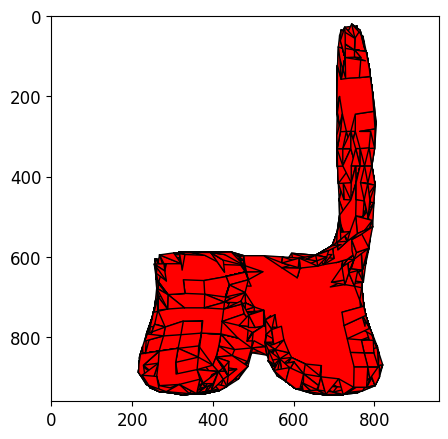

In [28]:
from networkx import Graph, cycle_basis
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
# 将所有线段的端点合并到一个列表中，并去重
points = corners.reshape(-1,2)

# 创建一个空的图
G = Graph()

# 将所有的点添加到图中
for point in points:
    G.add_node(tuple(point))

# 将所有的线段添加到图中
for line in lines3:
    G.add_edge(tuple(line[0]), tuple(line[1]))

# 找到图中所有的环
cycles = cycle_basis(G)

# 筛选出一个范围内的多边形

polys= [cycle for cycle in cycles if len(cycle) > 2 ]
# 将结果转换为所需的格式
print(len(polys))
# 创建一个新的图形
fig, ax = plt.subplots()

# 创建一个空的列表来存储所有的多边形
patches = []

for poly in polys:
    polygon = Polygon(poly, closed=True)
    patches.append(polygon)

# 创建一个PatchCollection，设置为红色，并添加到图形中
p = PatchCollection(patches, color='red',edgecolor='black')
ax.add_collection(p)


# 设置坐标轴的范围
ax.set_xlim(0, 960)
ax.set_ylim(0, 960)
ax.invert_yaxis()
# 显示图形
plt.show()

In [30]:
import numpy as np
import pandas as pd

# 预设的深度图像
depth_img = cv2.imread('c-4.png', cv2.IMREAD_GRAYSCALE)  # 读取深度图像
# 输入的坐标列表
coord_list=polys
# 转换坐标
xyz_coords = []
for sublist in coord_list:
    xyz_sublist = [(x, y, depth_img[y][x]) for (x, y) in sublist]
    xyz_coords.append(xyz_sublist)

# 输出为DataFrame
df = pd.DataFrame([item for sublist in xyz_coords for item in sublist], columns=['X', 'Y', 'Z'])
df.to_csv('poly_depth.csv', index=False)

# 输出为txt文件
with open('poly_depth.txt', 'w') as f:
    for sublist in xyz_coords:
        for item in sublist:
            f.write(','.join(map(str, item)) + ' ')
        f.write('\n')
with open('poly_depth.txt', 'r') as file:
    lines = file.readlines()

# 去除每一行末尾的空格
lines = [line.rstrip('\n') for line in lines]

with open('poly_depth1.txt', 'w') as f:
    for line in lines:
        f.write(line.strip())
        f.write('\n')
# 打开源文件
with open('poly_depth1.txt', 'r') as source_file:
    # 打开目标文件
    with open('polys_3.txt', 'w') as file3, open('polys_4.txt', 'w') as file4, open('polys_other.txt', 'w') as file_other:
        # 读取源文件的每一行
        for line in source_file:
            # 计算每一行中空格的数量
            space_count = line.count(' ')
            # 根据空格的数量将行写入不同的文件
            if space_count == 2:
                file3.write(line)
            elif space_count == 3:
                file4.write(line)
            else:
                file_other.write(line)

tri_grid: [[[551 443]
  [522 432]
  [527 452]]

 [[497 413]
  [499 440]
  [522 432]]

 [[475 415]
  [475 444]
  [499 440]]

 [[475 415]
  [454 411]
  [475 444]]

 [[412 378]
  [410 401]
  [440 386]]

 [[437 411]
  [410 401]
  [440 386]]

 [[327 403]
  [335 439]
  [348 411]]

 [[385 450]
  [354 467]
  [360 447]]

 [[385 450]
  [386 470]
  [354 467]]

 [[382 623]
  [415 607]
  [417 629]]

 [[444 610]
  [415 607]
  [417 629]]

 [[446 630]
  [415 607]
  [417 629]]

 [[417 651]
  [445 655]
  [417 629]]

 [[472 660]
  [449 683]
  [445 655]]

 [[475 685]
  [478 707]
  [449 683]]

 [[451 709]
  [478 707]
  [449 683]]

 [[498 706]
  [501 736]
  [478 707]]

 [[585 666]
  [551 698]
  [578 712]]

 [[722 559]
  [752 569]
  [697 569]]

 [[790 514]
  [810 522]
  [786 546]]

 [[790 514]
  [819 497]
  [810 522]]

 [[813 354]
  [817 332]
  [836 346]]

 [[817 382]
  [817 332]
  [836 346]]

 [[776 336]
  [792 353]
  [817 332]]

 [[813 354]
  [792 353]
  [817 332]]

 [[776 336]
  [751 357]
  [792 353]]

 [

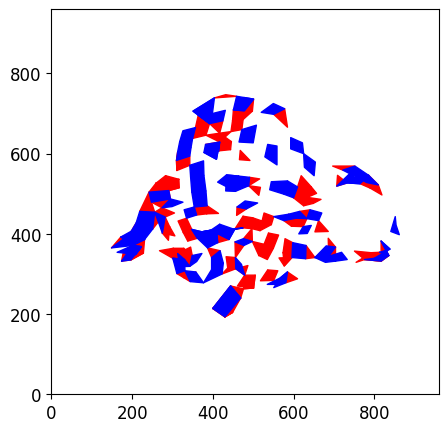

In [31]:
from networkx import Graph, cycle_basis
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
# 将所有线段的端点合并到一个列表中，并去重
points = corners.reshape(-1,2)

# 创建一个空的图
G = Graph()

# 将所有的点添加到图中
for point in points:
    G.add_node(tuple(point))

# 将所有的线段添加到图中
for line in lines3:
    G.add_edge(tuple(line[0]), tuple(line[1]))

# 找到图中所有的环
cycles = cycle_basis(G)

# 筛选出长度为3和4的环，即三角形和四边形
triangles = [cycle for cycle in cycles if len(cycle) == 3]
quadrilaterals = [cycle for cycle in cycles if len(cycle) == 4]
polys= [cycle for cycle in cycles if len(cycle) > 2 and len(cycle) < 10]
# 将结果转换为所需的格式
tri_grid = np.array(triangles).reshape(-1, 3, 2)
quad_grid = np.array(quadrilaterals).reshape(-1, 4, 2)


# 创建一个新的图形
fig, ax = plt.subplots()

# 创建一个空的列表来存储所有的多边形
patches = []

# 添加所有的三角形到列表中
for tri in tri_grid:
    polygon = Polygon(tri, closed=True)
    patches.append(polygon)

# 创建一个PatchCollection，设置为红色，并添加到图形中
p = PatchCollection(patches, color='red')
ax.add_collection(p)

# 清空列表，为添加四边形做准备
patches = []

# 添加所有的四边形到列表中
for quad in quad_grid:
    polygon = Polygon(quad, closed=True)
    patches.append(polygon)

# 创建一个PatchCollection，设置为蓝色，并添加到图形中
p = PatchCollection(patches, color='blue')
ax.add_collection(p)

# 设置坐标轴的范围
ax.set_xlim(0, 960)
ax.set_ylim(0, 960)

# 显示图形
plt.show()

In [22]:
#文件存储cell
# 将corners转换为字符串，每个元素占一行，x和y坐标由逗号分隔
corners_str = '\n'.join([','.join(map(str, corner[0])) for corner in corners])
# 打开一个文件，如果不存在则创建
file = open("corners926.txt", "w")
# 写入数据
file.write(corners_str)
# 关闭文件
file.close()
# 将数组转换为字符串，每行有两个坐标，坐标内部的x和y由逗号分隔，两个坐标之间由空格分隔
lines_str = '\n'.join(['{},{} {},{}'.format(line[0], line[1], line[2], line[3]) for line in lines3])
# 打开一个文件，如果不存在则创建
file = open("lines926.txt", "w")
# 写入数据
file.write(lines_str)
# 关闭文件
file.close()

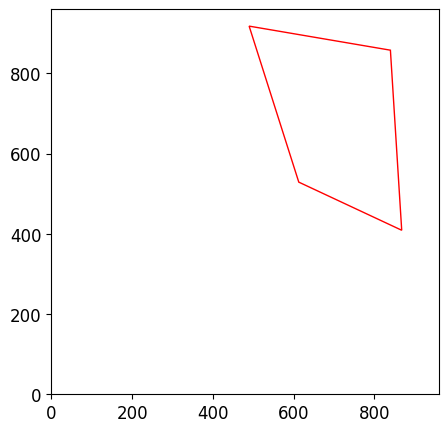

In [47]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# 假设你的四个顶点坐标是(1, 1)，(2, 3)，(3, 1)和(2, 2)
points = quad_grid[0]

# 创建一个新的图形
fig, ax = plt.subplots()

# 创建一个多边形
polygon = Polygon(points, fill=None, edgecolor='r')

# 将多边形添加到图形中
ax.add_patch(polygon)

# 设置x和y轴的限制以适应你的数据
ax.set_xlim(0, 960)
ax.set_ylim(0, 960)

# 显示图形
plt.show()

In [40]:
#深度检测与输出cell
corners=np.array(corners)
corners=corners.reshape(-1,2)
depth_img = cv2.imread('depth927.png', cv2.IMREAD_GRAYSCALE)  # 读取深度图像
# 首先，我们需要将点的坐标转换为整数，因为像素的索引必须是整数
corners=corners.astype(int)
depth_values = depth_img[corners[:, 1], corners[:, 0]]
points_depth = np.column_stack((corners, depth_values))
points_depth=np.array(points_depth)
np.savetxt('points_depth.txt', points_depth, fmt='%d', delimiter=', ')
lines3=lines3.reshape(-1, 2, 2)
depth_values_start = depth_img[lines3[:, 0, 1], lines3[:, 0, 0]]
depth_values_end = depth_img[lines3[:, 1, 1], lines3[:, 1, 0]]
lines_depth_start = np.column_stack((lines3[:, 0, :], depth_values_start))
lines_depth_end = np.column_stack((lines3[:, 1, :], depth_values_end))
lines_depth = np.stack((lines_depth_start, lines_depth_end), axis=1)
with open('lines_depth.txt', 'w') as f:
    for line in lines_depth:
        # 将每一行的两个三元组转化为字符串，然后写入文件
        f.write(','.join(map(str, line[0])) + ' ' + ','.join(map(str, line[1])) + '\n')

array([[361, 241, 244],
       [ 49, 356, 157],
       [351, 443, 232],
       ...,
       [480, 452, 102],
       [515, 441, 205],
       [472, 774, 181]])